In [4]:
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline 

from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import scipy

import warnings
warnings.filterwarnings("ignore")

In [5]:
df_negative = pd.read_csv('negative.csv')
df_positive = pd.read_csv('positive.csv')

In [6]:
df = pd.concat([df_negative[['ttext','ttype']],df_positive[['ttext','ttype']]])
df = df.sample(frac=1)
df.index = range(1,df.shape[0]+1)
df['ttype'] = df.loc[:,'ttype'].apply(lambda t: 0 if t == -1 else 1)

In [7]:
df.head(10)

,ttext,ttype
1,Доброе утро!) Всем отличного дня) http://t.co/...,1
2,"@cenobit_ohray картинка маленькая, ничо непоня...",0
3,"Видно плохо, но это Юпитер в телескопе) http:/...",1
4,RT @inside_only: @razzhiwintwitt охохохох) спа...,1
5,RT @mmmeeoooww: ДВАДЦАТЫЙ ТВИТ ДЛЯ @vladi_tric...,1
6,"Прочла в 5-ой книге ""Г.П..."" о воспоминании Сн...",0
7,@realydontcare82 да я тоже не оч умею((\r\nи н...,0
8,:(: - это смайлик Шредингера. Он весёлый и гру...,0
9,#жизньболь когда дома закончились печеньки ..((,0
10,"Только сейчас узнал.....(((( ""@vesti_news: Сле...",0


In [269]:
def preprocess(text:str) -> str :
    #text = re.sub(r"http:\S*","",text)
    emoticons = re.findall(r"[XХ:=][3зЗD()]+", text)
    emoticons += re.findall(r"[0оОoO]_[0оОoO]", text)
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    text = re.sub(r"@\S+[: ]","",text)
    text = re.sub(r"[XХ:][3ЗD()]+"," ", text)
    text = re.sub(r"[\n\r.,]"," ",text)
    text = re.sub(r"\W"," ",text)
    text = re.sub(r"[():!;?\"|]*","",text)
    text = re.sub(r"[#@][\S]*","",text)
    text = re.sub(r"RT","",text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r" {1,}", " ",text).strip()
    return str.lower(text) +" "+" ".join(emoticons)

In [270]:
df['text_clear'] = df['ttext'].apply(preprocess)

In [271]:
df['exclamations'] = df['ttext'].apply(lambda l: len(re.findall(r"!",l)))
df['sad_bracket'] = df['ttext'].apply(lambda l: len(re.findall(r"\(",l)))
df['happy_bracket'] = df['ttext'].apply(lambda l: len(re.findall(r"\)",l)))
df['upper_symbols'] = df['ttext'].apply(lambda l: len(list(filter(str.isupper,l))))

In [272]:
def show_example(df:pd.DataFrame):
    example = np.array(df.sample(5))
    for el in example:
        print("text :",el[0])
        print("text_clear: ",el[2])
        print("exclamation marks : ",el[3])
        print("sad br: ",el[4])
        print("happy br: ",el[5])
        print("upper symb: ",el[6])
        print("===================================")


In [226]:
show_example(df)

text : @SashkaBuryys @BalavinaD а еще ужастиков можно?
скучно же:)
text_clear:  а еще ужастиков можно скучно же :)
exclamation marks :  0
sad br:  0
happy br:  1
upper symb:  4
text : RT @OlegGazmanov: В России дали зеленую улицу продуктам из ГМО

Придётся заводить огород:( http://t.co/ny5OEEOxh3 http://t.co/kSLUqgGoIX
text_clear:  в россии дали зеленую улицу продуктам из гмо придётся заводить огород :(
exclamation marks :  0
sad br:  1
happy br:  0
upper symb:  20
text : Alexandr 3: Здравствуйте. Подскажите пожалуйста как долго нужно трахать девочку чтоб не опозорится? :-/ Мне уже 23 года а первый и после...
text_clear:  alexandr здравствуйте подскажите пожалуйста как долго нужно трахать девочку чтоб не опозорится мне уже года а первый и после 
exclamation marks :  0
sad br:  0
happy br:  0
upper symb:  4
text : @wylsacom gta sa теперь на первом месте в аппсторе) http://t.co/5WPwLWlGsH
text_clear:  gta sa теперь на первом месте в аппсторе 
exclamation marks :  0
sad br:  0
happy br:  

#### лемматизация не исправит ошибки в тексте + очень долго делается без gpu

In [139]:
import spacy

nlp = spacy.load("ru_core_news_sm")

text = "блииин голова заболела из за того что сижу и пялюсь в телефон аааааа :((("
doc = nlp(text)
lemmatized_words = [token.lemma_ for token in doc]
print(" ".join(lemmatized_words))

блииин голова заболеть из за того что сидеть и пялиться в телефон аааааа :(((


#### Визуализация

In [151]:
import seaborn as sns

In [152]:
sns.set_style("whitegrid")

#### Восклицательные знаки встречаются примерно одинаково, но в негативных сообщениях немного чаще

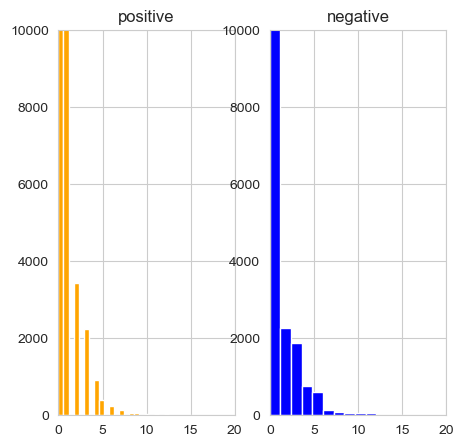

In [174]:
fig, axs = plt.subplots(1,2,figsize=(5,5))
axs[0].hist(df[df['ttype']==1]['exclamations'],color='orange',bins=100)
axs[0].set_title('positive')
axs[0].set_ylim(0,10000)
axs[0].set_xlim(0,20)

axs[1].hist(df[df['ttype']==0]['exclamations'],color='blue',bins=100);
axs[1].set_ylim(0,10000)
axs[1].set_xlim(0,20)
axs[1].set_title('negative');

#### То же самое, но для улыбающеся скобочки

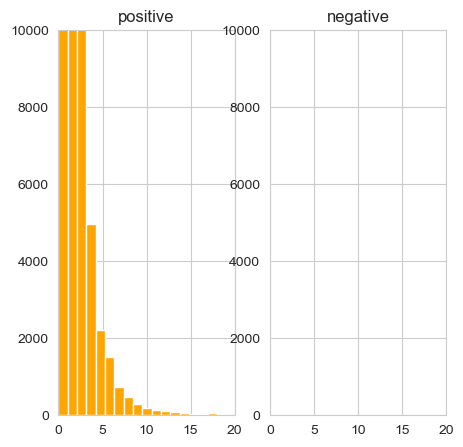

In [175]:
fig, axs = plt.subplots(1,2,figsize=(5,5))
axs[0].hist(df[df['ttype']==1]['happy_bracket'],color='orange',bins=100)
axs[0].set_title('positive')
axs[0].set_ylim(0,10000)
axs[0].set_xlim(0,20)

axs[1].hist(df[df['ttype']==0]['happy_bracket'],color='blue',bins=100);
axs[1].set_ylim(0,10000)
axs[1].set_xlim(0,20)
axs[1].set_title('negative');

#### Капслок в положительных сообщениях встречается чуть чаще

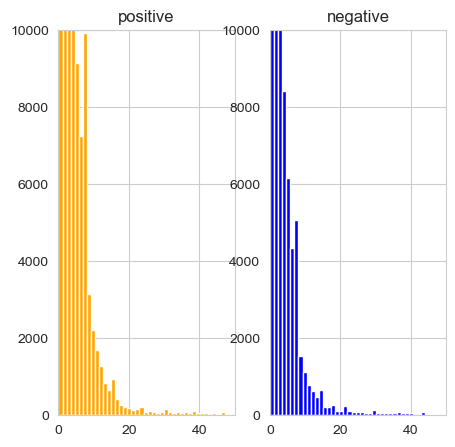

In [178]:
fig, axs = plt.subplots(1,2,figsize=(5,5))
axs[0].hist(df[df['ttype']==1]['upper_symbols'],color='orange',bins=100)
axs[0].set_title('positive')
axs[0].set_ylim(0,10000)
axs[0].set_xlim(0,50)

axs[1].hist(df[df['ttype']==0]['upper_symbols'],color='blue',bins=100);
axs[1].set_ylim(0,10000)
axs[1].set_xlim(0,50)
axs[1].set_title('negative');

#### Грустная скобочка

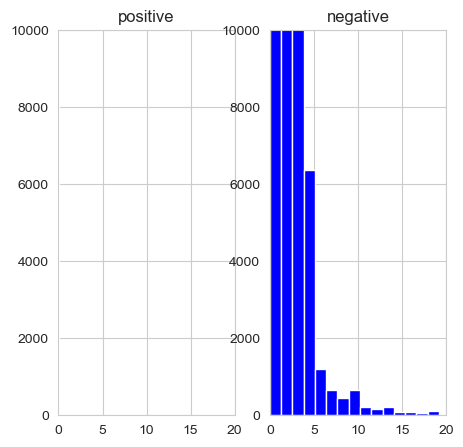

In [179]:
fig, axs = plt.subplots(1,2,figsize=(5,5))
axs[0].hist(df[df['ttype']==1]['sad_bracket'],color='orange',bins=100)
axs[0].set_title('positive')
axs[0].set_ylim(0,10000)
axs[0].set_xlim(0,20)

axs[1].hist(df[df['ttype']==0]['sad_bracket'],color='blue',bins=100);
axs[1].set_ylim(0,10000)
axs[1].set_xlim(0,20)
axs[1].set_title('negative');

#### Скачал список матерных слов, но, как видно, в среднем они встречаются редко во всех классах

In [195]:
curse_words = []
with open("ru_curse_words.txt","r",encoding="UTF-8") as bad_words:
    curse_words =bad_words.read()
curse_words = re.sub(r"\n"," ",curse_words)
curse_words = curse_words.split();

In [228]:
df['curse'] = df['ttext'].apply(lambda l: sum([curse in l for curse in curse_words]))

In [238]:
df.groupby('ttype')['curse'].describe()

,count,mean,std,min,25%,50%,75%,max
ttype,,,,,,,,
0,111923.0,0.153588,0.533453,0.0,0.0,0.0,0.0,10.0
1,114911.0,0.087137,0.394247,0.0,0.0,0.0,0.0,9.0


In [324]:
X_train, X_test, y_train, y_test = \
    train_test_split(df[['text_clear','exclamations','sad_bracket','happy_bracket','upper_symbols']],
                     df['ttype'], test_size=0.33, random_state=42)

In [274]:
def log_reg(X_train,y_train):
    cv = TfidfVectorizer(ngram_range=(1,2))
    sparse_train = cv.fit_transform(X_train['text_clear'])
    #sparse_tr = scipy.sparse.csr_matrix(X_train[['exclamations','sad_bracket','happy_bracket','upper_symbols']])
    #sparse_train = scipy.sparse.hstack([sparse_train,sparse_tr])
    lg = LogisticRegression(solver='saga',random_state=0,n_jobs=-1)
    lg.fit(sparse_train,y_train)
    return lg,cv

In [285]:
def roc_auc_test(X_test,y_test,model,cv):
    data_clean = prepare_data(X_test,cv)
    prediction = model.predict_proba(data_clean)[:,1]
    return roc_auc_score(y_test,prediction)

In [290]:
def prepare_data(df,cv):
    #df['exclamations'] = df['ttext'].apply(lambda l: len(re.findall(r"!",l)) > 0)
    #df['sad_bracket'] = df['ttext'].apply(lambda l: len(re.findall(r"\(",l)) > 0)
    #df['happy_bracket'] = df['ttext'].apply(lambda l: len(re.findall(r"\)",l))>0)
    #df['upper_symbols'] = df['ttext'].apply(lambda l: len(list(filter(str.isupper,l)))>0)
    #df['text_clear'] = df['ttext'].apply(preprocess)
    sparse_train = cv.transform(df['text_clear'])
    #sparse_tr = scipy.sparse.csr_matrix(df[['exclamations','sad_bracket','happy_bracket','upper_symbols']])
    #sparse_train = scipy.sparse.hstack([sparse_train,sparse_tr])
    return sparse_train

In [287]:
def words_importance(model,cv):
    words = cv.get_feature_names_out()
    coefs = model.coef_[0]
    z = list(zip(words,coefs))
    z = sorted(z,key=lambda l:l[1],reverse=True)
    for el in z[:20]:
        print(el)
    print("----------------")
    for el in z[-20:-1]:
        print(el)
    return z

In [278]:
clf,cv = log_reg(X_train,y_train)

In [312]:
roc_auc_test(X_test,y_test,clf,cv)

0.8418712601479534

#### Смайлики снова не оказались учтены, что странно, на этот раз я их не удалял

In [318]:
importance = words_importance(clf,cv)

('dd', 11.53067649619288)
('ddd', 8.34748753760165)
('спасибо', 7.276355393394182)
('ахаха', 6.5750375875112015)
('ахах', 6.467564507593682)
('приятно', 6.321460356722182)
('ахахах', 6.311103530003446)
('xd', 4.929728202205769)
('обожаю', 4.8377653918842105)
('так что', 4.378721807169547)
('dddd', 4.37815347957205)
('євромайдан', 4.34067932430545)
('люблю', 4.315235332580174)
('ахахаха', 4.171521094887264)
('круто', 4.124867004804196)
('наконец', 4.06959737674229)
('хаха', 4.029849628397094)
('весело', 3.974708293535652)
('хорошо', 3.959449776674641)
('ура', 3.935433369212986)
----------------
('плохо', -5.3068105491498345)
('болит', -5.369066647507893)
('не могу', -5.369327188784849)
('нет', -5.620185330021364)
('сожалению', -5.65133557285126)
('печаль', -5.990763143568956)
('хочу', -6.238493296544657)
('опять', -6.281247656466021)
('печально', -6.3469468331210575)
('ужасно', -6.38039718654185)
('ненавижу', -6.45568132962184)
('скучаю', -6.943069826583088)
('грустно', -6.9458453603979

#### Смайликов нет в словаре в принципе, tf-idf счел их ненужными?

In [344]:
print(list(cv.vocabulary_.keys())[:15])
try:
    print(cv.vocabulary_[":D"])
except Exception:
    print("отсутствует в словаре")

['уууууииим', 'вот', 'это', 'очень', 'слишком', 'плохо', 'уууууииим вот', 'вот это', 'это очень', 'очень слишком', 'слишком плохо', 'чем', 'связанно', 'как', 'исправить']
отсутствует в словаре


In [267]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

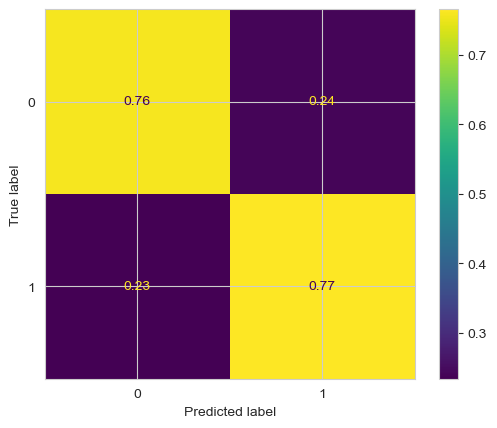

In [317]:
cm = confusion_matrix(y_test, clf.predict(prepare_data(X_test,cv)),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [311]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

In [313]:
clean_data = prepare_data(X_test,cv)
y_scores = clf.predict_proba(clean_data)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

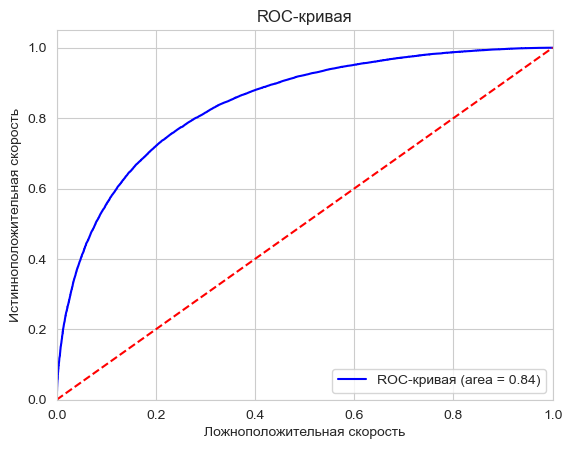

In [314]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC-кривая (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного угадывания
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная скорость')
plt.ylabel('Истинноположительная скорость')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#### Порог лучше установить где то на 0.75 и 0.8, а на промежутке (0.25,0.75) считать, что модель не знает, как классифицировать.
#### Если такой ИИ считает слово "евромайдан" признаком положительности сообщения, то он предоставляет угрозу для государственной безопасности.. не буду торопиться с деплоем

#### Красивая визуализация важности слов для модели

In [345]:
most_positive = importance[:100]
most_negative = importance[-100:-1]

In [346]:
from wordcloud import WordCloud

In [347]:
wordcloud_positive = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600).generate_from_frequencies(dict(most_positive))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600).generate_from_frequencies(dict(most_negative))

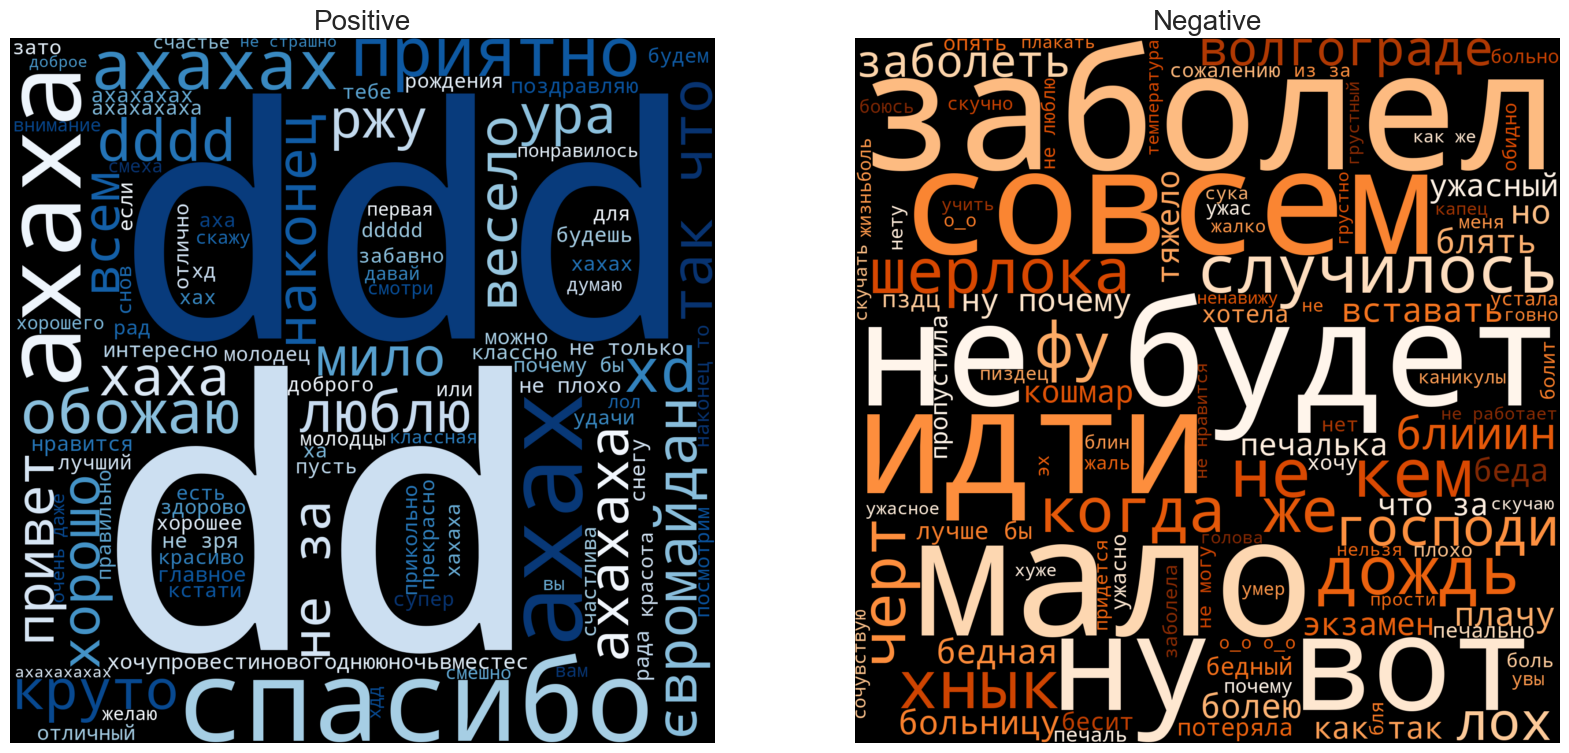

In [348]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Positive',
               fontsize = 20
               )
ax[1].set_title('Negative',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

In [407]:
s = ['грустно','жалко :D','весело']

In [408]:
text = pd.DataFrame({"ttext":s})
text['text_clear'] = text['ttext'].apply(preprocess)
print(text['text_clear'])
clean_text = prepare_data(text,cv)

0    грустно 
1    жалко :D
2     весело 
Name: text_clear, dtype: object


In [406]:
clf.predict_proba(clean_text)[:,1]

array([0.00151039, 0.00103576, 0.98818705])